<a href="https://colab.research.google.com/github/etetteh/Works/blob/master/Enoch_Variational_Autoencoders_CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

This practical session will concentrate on generative modeling with Variational Autoencoders. We will implement the model and train it on MNIST. We will also implement a couple of functions which will allow us to visualize the latent space and image reconstructions based on a trained model. A great tutorial is available [here](https://arxiv.org/abs/1606.05908).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.sandbox.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb). Enable a free GPU by going to:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


In [0]:
#@title Imports
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, MaxPool2D, BatchNormalization, ReLU
from tensorflow.keras.layers import BatchNormalization, ReLU, Input, AveragePooling2D, Flatten
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline



In [0]:
#@title Loading MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Model and loss

As discussed in the lecture, the VAE consists of an encoder and a decoder. In this example, we will set up a simple 3-layer neural network for both. 

1.   The encoder will output the mean and variance parametrizing the approximate posterior.
2.   The decoder will output a value in [0, 1] for each output pixel.

The loss function is the sum of the reconstruction error and the average mismatch between the approximate posterior and the prior measured by KL divergence. Note that in this case both the prior and approximate posterior are multivariate Gaussian distributions for which the KL divergence can be computed in closed-form.

**Basic operations**
1.   **Encoding:** Infering the latent representation of the given input: X -> Z
2.   **Decoding:** Generating the instance corresponding to the given code: Z -> X
3.   **Transmitting:** Encoding followed by decoding of the given input.



In [0]:
class VAE(object):

  def __init__(self, x_dim, z_dim, activation=tf.nn.elu, eps=1e-8):
    self.sess = tf.InteractiveSession()
    self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, x_dim])
    self.z_dim = z_dim
    self.build(x_dim, z_dim, activation, eps)

  def __del__(self):
    print("Cleaning up the session.")
    self.sess.close()

  def build(self, input_dim, z_dim, activation, eps):
    input_shape = tf.reshape(self.x, shape=(-1,28,28,1))
    
    with tf.variable_scope("encoder"):
      conv_0 = Conv2D(512, kernel_size=3, padding='same')(input_shape) 
      batch_norm_0 = BatchNormalization()(conv_0)
      nl_0 = ReLU()(batch_norm_0)
      max_pool_0 = MaxPool2D(pool_size=(2, 2))(nl_0)
      
      conv_1 = Conv2D(256, kernel_size=3, padding='same')(max_pool_0) 
      batch_norm_1 = BatchNormalization()(conv_1)
      nl_1 = ReLU()(batch_norm_1)
      max_pool_1 = MaxPool2D(pool_size=(2, 2))(nl_1)
        
      conv_2 = Conv2D(128, kernel_size=3, padding='same')(max_pool_1) 
      batch_norm_2 = BatchNormalization()(conv_2)
      nl_2 = ReLU()(batch_norm_2)
      max_pool_2 = MaxPool2D(pool_size=(2, 2))(nl_2)
        
      conv_3 = Conv2D(64, kernel_size=3, padding='same')(max_pool_2) 
      batch_norm_3 = BatchNormalization()(conv_3)
      nl_3 = ReLU()(batch_norm_3)
      avg_pool_3 = MaxPool2D(pool_size=(2, 2))(nl_3)
      
      flat = Flatten()(avg_pool_3)
      
      z_mu = Dense(z_dim, activation=None)(flat)
      z_log_sigma_sq = Dense(z_dim, activation=None)(flat)
      
    with tf.variable_scope("latent_space"):
      std_gauss = tf.random_normal(
        shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
      self.z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * std_gauss

    with tf.variable_scope("decoder"):
      net = Dense(784, activation=None)(self.z)
      input_shape_d = tf.reshape(net,shape=(-1,28,28,1))
       
      convT_1 = Conv2DTranspose(784, kernel_size=3, padding='same')(input_shape_d) 
      batch_normT_1 = BatchNormalization()(convT_1)
      nlT_1 = ReLU()(batch_normT_1)
#       max_poolT_1 = MaxPool2D(pool_size=(2, 2))(nlT_1)
        
      convT_2 = Conv2DTranspose(128, kernel_size=3, padding='same')(nlT_1) 
      batch_normT_2 = BatchNormalization()(convT_2)
      nlT_2 = ReLU()(batch_normT_2)
#       max_poolT_2 = MaxPool2D(pool_size=(2, 2))(nlT_2)
        
      convT_3 = Conv2DTranspose(256, kernel_size=3, padding='same')(nlT_2) 
      batch_normT_3 = BatchNormalization()(convT_3)
      nlT_3 = ReLU()(batch_normT_3)
#       avg_poolT_3 = AveragePooling2D(pool_size=(2, 2))(nlT_3)
              
      flatT = Flatten()(nlT_3)
      self.x_hat = Dense(input_dim, activation='sigmoid')(flatT)
    
    with tf.variable_scope("loss"):
      reconstruction_loss = tf.reduce_mean(
        -tf.reduce_sum(
          self.x * tf.log(self.x_hat + eps) + 
          (1 - self.x) * tf.log(1 - self.x_hat + eps), axis=1))

      prior_mismatch_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(
        1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1))   # the KL divergence part of the loss  
      self.loss = reconstruction_loss + prior_mismatch_loss  

  def encode(self, x):
    return self.sess.run(self.z, feed_dict={self.x: x})
    
  def decode(self, z):
    return self.sess.run(self.x_hat, feed_dict={self.z: z})

  def transmit(self, x):
    return self.sess.run(self.x_hat, feed_dict={self.x: x})

## Training

We will minimize the VAE loss using the [Adam optimizer](https://arxiv.org/abs/1412.6980). We will provide the learning rate, batch size and the total number of batches to process during optimization. Note that this loss function is non-convex in the parameters of the encoder and decoder. Hence,  when using stochastic minibatch optimization, there are no guarantees on the quality of the solution nor on the convergence. 



In [0]:
def train(vae, learning_rate=1e-3, batch_size=256, n_batches=100):
  with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(vae.loss)
    vae.sess.run(tf.global_variables_initializer())
    for batch_idx in range(n_batches):
      batch = mnist.train.next_batch(batch_size)[0]
      current_loss, _ = vae.sess.run([vae.loss, train_op], feed_dict={
        vae.x: batch
      })
      if batch_idx % int(n_batches / 10) == 0:
        print("[Batch [%05d] -> loss[%.2f]" % (batch_idx, current_loss))

In [0]:

vae = VAE(x_dim=28*28, z_dim=32)
train(vae, n_batches=7001)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Batch [00000] -> loss[543.50]


KeyboardInterrupt: ignored

## Reconstructions and random samples
We will pick a batch of images from MNIST and transmit them through the trained VAE. For each input image we will show the resulting reconstruction.

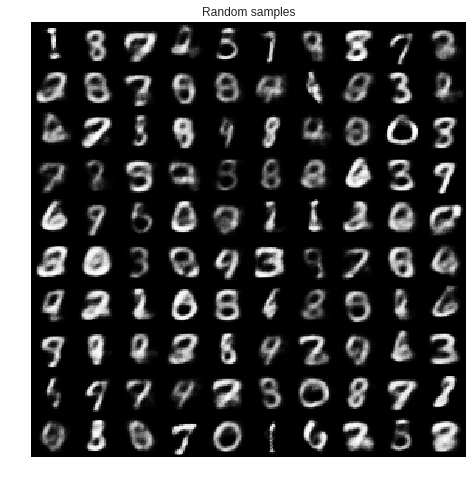

In [0]:
def plot(fig_height, fig_width, canvas, title):
  plt.figure(figsize=(fig_height, fig_width))
  plt.imshow(canvas, cmap='gray')
  plt.axis('off')
  plt.title(title)

def visualize_random_samples(model, batch_size=1024):
  n = int(np.sqrt(batch_size))
  h = w = int(np.sqrt(model.x.shape.as_list()[1]))
  z = np.random.normal(size=[batch_size, model.z_dim])
  x_generated = model.decode(z).reshape([n, n, h, w])
  canvas = np.zeros((h * n, w * n))
  for i in range(n):
    for j in range(n):
      canvas[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i][j]
  plot(8, 8, canvas, "Random samples")

visualize_random_samples(vae, 100)

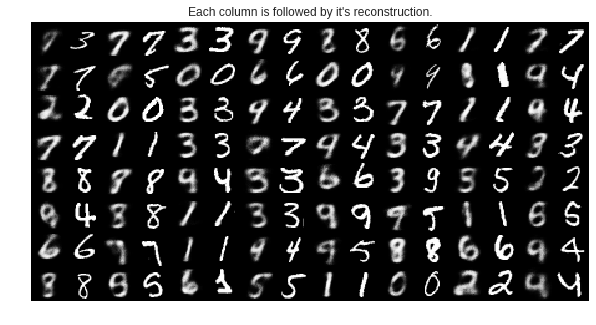

In [0]:
def visualize_reconstructions(model, mnist, batch_size=64):
    n = int(np.sqrt(batch_size))
    h = w = int(np.sqrt(model.x.shape.as_list()[1]))
    batch = mnist.test.next_batch(batch_size)[0]
    x_hat = model.transmit(batch)
    canvas = np.zeros((h * n, w * n * 2))
    for i in range(n):
      for j in range(n):
        canvas[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = np.concatenate(
          (x_hat[i*n+j, :].reshape(h, w), batch[i*n+j, :].reshape(h, w)), axis=1)
    plot(10, 20, canvas, "Each column is followed by it's reconstruction.")

visualize_reconstructions(vae, mnist, batch_size=64)

## 2D latent space for MNIST

We will now train a VAE which maps each NNIST image (d=28*28=784) into 2 dimensions. Then, we will visualize this 2D space. Then, we will show the decoded samples for all codes in [-1, 1] x [-1, 1].

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Batch [00000] -> loss[543.80]
[Batch [01600] -> loss[100.04]
[Batch [03200] -> loss[77.05]
[Batch [04800] -> loss[64.42]
[Batch [06400] -> loss[64.86]
[Batch [08000] -> loss[63.23]
[Batch [09600] -> loss[62.30]
[Batch [11200] -> loss[62.13]
[Batch [12800] -> loss[59.33]
[Batch [14400] -> loss[58.46]


InvalidArgumentError: ignored

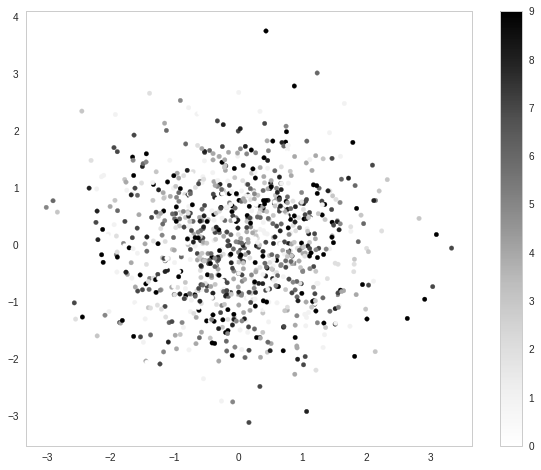

In [0]:
def visualize_latent_2d(model, batch_size=1024):
  x, y = mnist.test.next_batch(batch_size)
  z = model.encode(x)
  h = w = int(np.sqrt(model.x.shape.as_list()[1]))

  plt.figure(figsize=(10, 8))
  plt.scatter(z[:, 0], z[:, 1], c=np.argmax(y, 1), s=20)
  plt.colorbar()
  plt.grid()

  n = 20
  x = y = np.linspace(-2, 2, n)
  canvas = np.empty((h*n, w*n))
  for i, yi in enumerate(x):
      for j, xi in enumerate(y):
          z = np.array([[xi, yi]] * 64)
          x_hat = model.decode(z)
          canvas[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)
  plt.figure(figsize=(8, 8))        
  plt.imshow(canvas, cmap="gray")
  plt.axis('off')

tf.reset_default_graph()
vae_2d = VAE(x_dim=28*28, z_dim=2)
train(vae_2d, n_batches=16000)

visualize_latent_2d(vae_2d)    